In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier





In [ ]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")

In [20]:
targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)

In [17]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    #'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict')   
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)


In [ ]:
def create_model(optimizer="adam", loss='sparse_categorical_crossentropy', activation='relu', layers=2, neurons=80):
    model = Sequential()
    model.add(Input(shape=(36,)))
    for layer in range(1,layers+1):
        model.add(Dense(int(neurons/layer), activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
keras_class_param = {         
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'leaky_relu', 'swish', 'sigmoid '], 
    'model__loss': ['sparse_categorical_crossentropy'],
    'model__layers': [2],
    'model__neurons': [80],
}

keras_class_model = KerasClassifier(model=create_model, verbose=0)
keras_estimators, keras_scores_train, keras_scores_test, keras_cv_results = train(features, targets, keras_class_model, keras_class_param, outer_splits=3, inner_splits=2)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

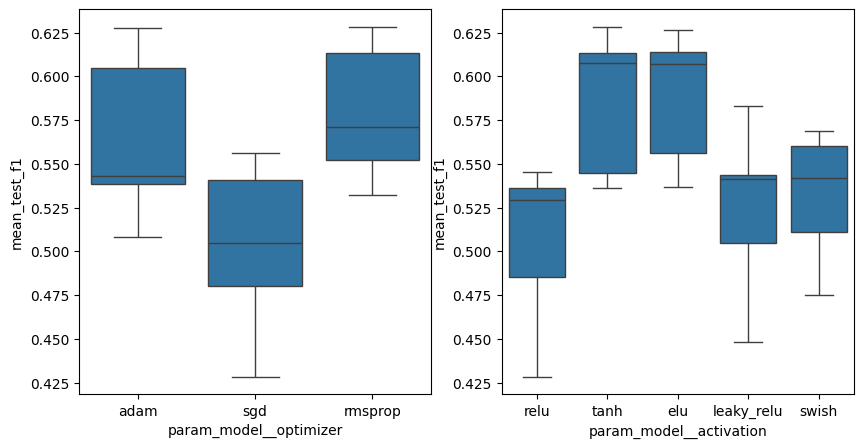

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results, x='param_model__optimizer', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results, x='param_model__activation', y='mean_test_f1', ax=ax[1])


In [18]:
keras_scores_test

,accuracy,precision,recall,f1
0,0.738305,0.672428,0.640195,0.646908
1,0.751864,0.696821,0.633547,0.634375
2,0.763908,0.699949,0.651441,0.652032


In [19]:
keras_estimators

[KerasClassifier(
 	model=<function create_model at 0x000002720176D120>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=1
 	class_weight=None
 	model__activation=tanh
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002720176D120>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=1
 	class_weight=None
 	model__activation=elu
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_

In [118]:
keras_class_param_2 = {
    'batch_size': [10],
    'epochs': [10],     
    'model__optimizer': ['rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'leaky_relu', 'swish'], 
    'model__loss': ['sparse_categorical_crossentropy'],
    'model__layers': [1, 2, 3],
    'model__neurons': [80],
}
keras_class_model_2 = KerasClassifier(model=create_model, verbose=0)
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_class_model_2, keras_class_param_2, outer_splits=3, inner_splits=2)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

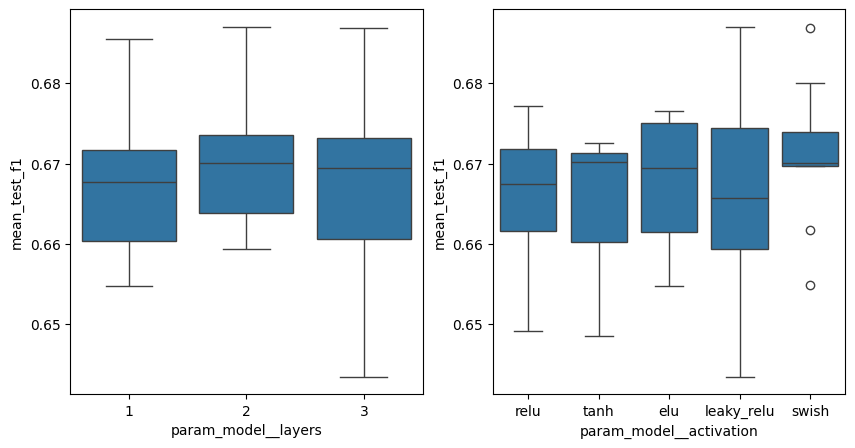

In [120]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_2, x='param_model__layers', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_2, x='param_model__activation', y='mean_test_f1', ax=ax[1])

In [121]:
keras_scores_test_2

,accuracy,precision,recall,f1
0,0.752542,0.691519,0.680938,0.685301
1,0.756610,0.692469,0.673387,0.679211
2,0.764586,0.703474,0.673878,0.680476


In [122]:
keras_scores_train_2

,accuracy,precision,recall,f1
0,0.819939,0.778989,0.759380,0.767472
1,0.818583,0.784137,0.750551,0.762638
2,0.841017,0.829381,0.774819,0.792299


In [123]:
keras_estimators_2

[KerasClassifier(
 	model=<function create_model at 0x0000016D9A495C60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=leaky_relu
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x0000016D9A495C60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=tanh
 	model__layers=2
 	model__loss=sparse_categorical_crossentropy
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function cr